# Préparation des données


In [2]:
# Import des bibliothèque
import pandas as pd  
import numpy as np  
from sklearn.model_selection import train_test_split
import xgboost as xgb


# Lecture du CSV
adult = pd.read_csv('adult.csv')

In [3]:
adult = adult.drop('fnlwgt', axis=1)

In [6]:
adult.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   education        48842 non-null  object
 3   educational-num  48842 non-null  int64 
 4   marital-status   48842 non-null  object
 5   occupation       46033 non-null  object
 6   relationship     48842 non-null  object
 7   race             48842 non-null  object
 8   gender           48842 non-null  object
 9   capital-gain     48842 non-null  int64 
 10  capital-loss     48842 non-null  int64 
 11  hours-per-week   48842 non-null  int64 
 12  native-country   47985 non-null  object
 13  income           48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


Certaines variables contiennent des valeurs manquantes représentées par des ‘ ?’. 


XGBoost est conçu pour gérer en interne les valeurs manquantes, s’il existe une tendance pour les valeurs manquantes, elle est capturée par le modèle, mais pour cela il faut que celles-ci soient identifiées comme telles.


In [4]:
adult = adult.replace('?', np.nan)

Certaines variables sont des variables catégorielles contenant un nombre élevé de modalités. C'est le cas par exemple de education ou native-country.
Les variables education et educational-num étant redondantes, on pourra se passer de la première.
Pour ce qui est de la variable native-country, un coup d'œil à ses labels nous indique que près de 90% de la population vient des Etats-Unis alors que 40 pays sont représentés, on peut donc décider de regrouper ces labels par région du monde.


In [7]:
adult = adult.drop('education', axis=1)

adult.replace(['Cambodia', 'China', 'Hong', 'India', 'Iran', 'Japan',
               'Laos', 'Philippines', 'Taiwan', 'Thailand', 'Vietnam'], 'Asia', inplace=True)

adult.replace(['Columbia', 'Cuba', 'Dominican-Republic', 'Ecuador', 'El-Salvador',
               'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua',
                'Peru', 'Puerto-Rico', 'Trinadad&Tobago', 'South'], 'Center & South America', inplace=True)

adult.replace(['England', 'France', 'Germany', 'Greece', 'Holand-Netherlands', 'Hungary', 
               'Ireland', 'Italy', 'Poland', 'Portugal', 'Scotland', 'Yugoslavia'], 'Europe', inplace=True)

adult.replace(['United-States', 'Canada'], 'Canada&USA', inplace=True)


XGBoost ne travaille qu’avec des vecteurs numériques : il faudra convertir toutes les variables catégorielles en variables numériques. 


La solution le plus simple pour cela est l’encodage ‘One-hot’, ou ‘dummification’ en anglais, qui consiste en la création pour chaque variable d’autant de variables dichotomiques que de modalités présentes. 


In [8]:
# Séparation des varaible explicative et variables de prédiction
features = adult.drop('income', axis=1)
target = adult['income']

#Transformation des labels '>50k' et '<=50k' de target en 1 et 0
target= [1 if x==">50K" else 0 for x in target]

# Matrice des variables catégorielles = dichotomisées
features_matrix = pd.get_dummies(features)

In [12]:
# Création ensemble de validation
X, X_valid, y, y_valid = train_test_split(features_matrix, target, test_size=0.1)

# Création ensemble d'apprentissage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


L'une des particularités de XGBoost est que cet algorithme nécessite que les données soient au format matrix (il n'accepte donc pas DataFrames par exemple).

Le package xgboost permet de créer un objet xgb.DMatrix contenant la matrice des variables et le vecteur des prédictions, à insérer respectivement dans les arguments data et label.

In [13]:
train = xgb.DMatrix(data=X_train, label=y_train)
test = xgb.DMatrix(data=X_test, label=y_test)
valid = xgb.DMatrix(data=X_valid, label=y_valid)

# Paramètres réglables dans XGBoost

XGBoost contient sa propre fonction train() qui permet d'entraîner un modèle, en précisant le jeu d'entraînement et les différents paramètres à régler.

XGBoost contient un grand nombre d’hyperparamètres qui peuvent être modifiés et réglés pour augmenter la précision.
Chaque paramètre a un rôle significatif à jouer dans la performance du modèle.

Au-delà de la régression et de la classification, XGBoost supporte toutes les fonctions objectif définies par l'utilisateur, ainsi que les métriques d'évaluations personnalisées. Ce qui lui donne une grande flexibilité.

Le paramètre dtrain permet de préciser la matrice d'entraînement à utiliser, et evals prend une liste en argument qui lui permet d'afficher les scores obtenus pour les échantillons qu'elle contient.

In [14]:
# Création dictionnaire params
params = {'booster':'gbtree', 'learning_rate':1, 'objective':'binary:logistic'}

# Entrainement 
xgb1 = xgb.train(params=params, dtrain=train, num_boost_round=100, evals=[(train, 'train'), (test, 'eval')])



[0]	train-logloss:0.36340	eval-logloss:0.36501
[1]	train-logloss:0.31394	eval-logloss:0.32217
[2]	train-logloss:0.29843	eval-logloss:0.31018
[3]	train-logloss:0.28711	eval-logloss:0.30036
[4]	train-logloss:0.27906	eval-logloss:0.29340
[5]	train-logloss:0.27402	eval-logloss:0.29118
[6]	train-logloss:0.27034	eval-logloss:0.28969
[7]	train-logloss:0.26724	eval-logloss:0.29018
[8]	train-logloss:0.26588	eval-logloss:0.28837
[9]	train-logloss:0.26446	eval-logloss:0.28744
[10]	train-logloss:0.26185	eval-logloss:0.28821
[11]	train-logloss:0.25899	eval-logloss:0.28990
[12]	train-logloss:0.25803	eval-logloss:0.28969
[13]	train-logloss:0.25592	eval-logloss:0.28886
[14]	train-logloss:0.25500	eval-logloss:0.28834
[15]	train-logloss:0.25316	eval-logloss:0.28848
[16]	train-logloss:0.25156	eval-logloss:0.28687
[17]	train-logloss:0.25056	eval-logloss:0.28797
[18]	train-logloss:0.24947	eval-logloss:0.28878
[19]	train-logloss:0.24777	eval-logloss:0.28983
[20]	train-logloss:0.24712	eval-logloss:0.28940
[2

Avec un learning_rate=1, on s'aperçoit que très rapidement, l'erreur de l'échantillon de validation cesse de décroître, et l'écart se creuse entre les deux erreurs au fur et à mesure des itérations.


A chaque itération de l'algorithme de Gradient Boosting, de nouveaux arbres sont créés pour corriger les erreurs résiduelles dans les prédictions à partir de la séquence d'arbres existante.


Ainsi, le modèle peut s'adapter très rapidement, puis overfitter sur l'ensemble de données d'apprentissage.


Une technique pour ralentir l'apprentissage dans l'algorithme de Gradient Boosting consiste à appliquer un facteur de pondération pour les corrections apportées par les nouveaux arbres lorsqu'ils sont ajoutés au modèle.


Cette pondération s'appelle, le plus souvent, le learning rate.
En ajoutant ce facteur de rétrécissement (i.e. un learning_rate <1), l'ajout de chaque arbre aura un impact diminué sur le modèle, en conséquence un plus grand nombre d'arbres doivent être ajoutés au modèle.


En outre, plus le learning_rate est bas, mieux le modèle converge vers son optimum, mais plus cette convergence est longue, donc l'entraînement du modèle plus lent.
A l'inverse, un learning_rate élevé permet un entraînement plus rapide, mais moins optimal.


Pour profiter au mieux de XGBoost, il faut donc privilégier le learning_rate le plus bas possible et un nombre d'arbres élevé, tout en gardant un temps de calcul raisonnable.


In [15]:
# Paramètre
params = {'booster': 'gbtree', 'learning_rate': 0.01, 'objective': 'binary:logistic'}

# Nouveau modèle entraînement
xgb2 = xgb.train(params=params, dtrain=train, num_boost_round=700, evals=[(train, 'train'), (test, 'eval')])


[0]	train-logloss:0.68727	eval-logloss:0.68728
[1]	train-logloss:0.68144	eval-logloss:0.68150
[2]	train-logloss:0.67573	eval-logloss:0.67583
[3]	train-logloss:0.67013	eval-logloss:0.67027
[4]	train-logloss:0.66469	eval-logloss:0.66485
[5]	train-logloss:0.65931	eval-logloss:0.65949
[6]	train-logloss:0.65401	eval-logloss:0.65423
[7]	train-logloss:0.64883	eval-logloss:0.64908
[8]	train-logloss:0.64373	eval-logloss:0.64403
[9]	train-logloss:0.63873	eval-logloss:0.63906
[10]	train-logloss:0.63382	eval-logloss:0.63418
[11]	train-logloss:0.62904	eval-logloss:0.62942
[12]	train-logloss:0.62431	eval-logloss:0.62473
[13]	train-logloss:0.61966	eval-logloss:0.62011
[14]	train-logloss:0.61513	eval-logloss:0.61561
[15]	train-logloss:0.61064	eval-logloss:0.61116
[16]	train-logloss:0.60623	eval-logloss:0.60679
[17]	train-logloss:0.60190	eval-logloss:0.60250
[18]	train-logloss:0.59768	eval-logloss:0.59831
[19]	train-logloss:0.59349	eval-logloss:0.59416
[20]	train-logloss:0.58938	eval-logloss:0.59010
[2

On remarque facilement que l'apprentissage se fait plus lentement, et que l'écart entre l'erreur d'apprentissage et de test et fortement réduit.


Cependant, l'erreur d'évaluation finale est déjà approximativement atteinte avant la fin des 700 itérations, or chaque itération peut s'avérer coûteuse en temps de calcul dans certains cas, comme par exemple lors d'une évaluation du modèle par validation croisée.


Pour éviter de perdre du temps précieux, il est possible d'utiliser le paramètre early_stopping_rounds pour arrêter l'apprentissage lorque l'erreur de validation ne diminue plus au-delà d'un certain nombre d'itération.


Si early_stopping_rounds est utilisé, le modèle aura 3 attributs supplémentaires best_score, best_iteration et best_ntree_limit.


Par défaut, le modèle retourné sera celui de la dernière itération. Pour utiliser le meilleur afin d'effectuer des prédictions, il est possible d'utiliser par exemple xgb_model.predict(test, ntree_limit= xgb_model.best_ntree_limit).


La fonction xgb.plot_importance permet d'afficher un graphique en barres affichant par ordre décroissant l'importance de chaque feature pour un modèle.


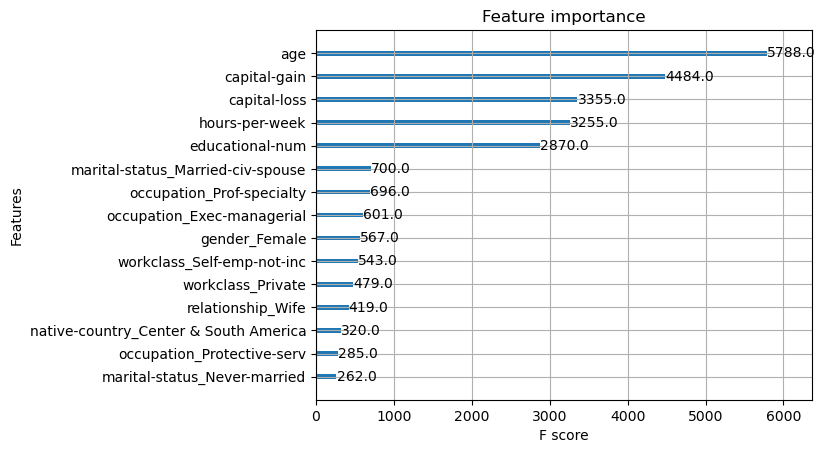

In [16]:
# Affichage graphique d'importance pour xgb2, limite variable 15
xgb.plot_importance(xgb2, max_num_features=15);

En observant le graphique obtenu, on constate que l'âge domine les autres variables, se démarquant clairement comme le prédicteur le plus important du revenu.


Nous pourrions nous arrêter ici et conclure par la réponse intuitivement satisfaisante que l'âge est la variable la plus importante, suivie des heures travaillées par semaine et du niveau de scolarité.

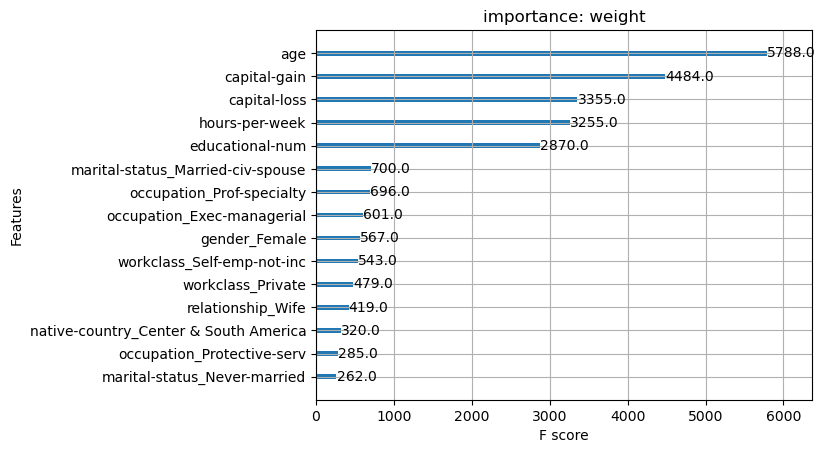

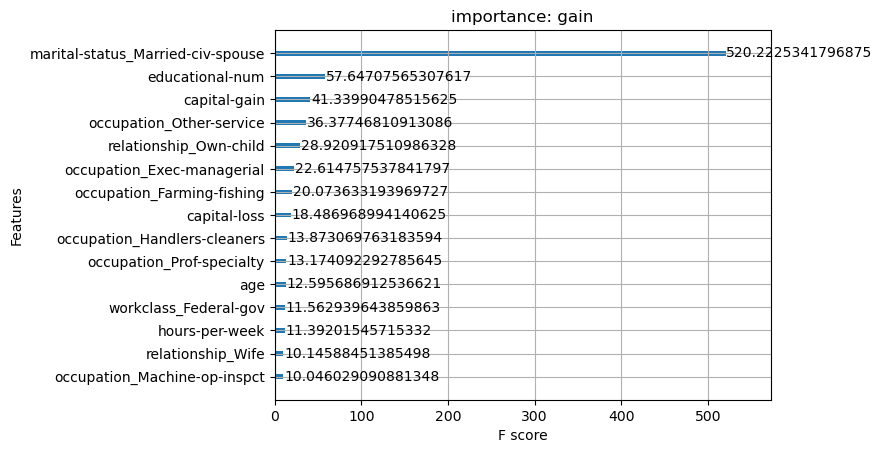

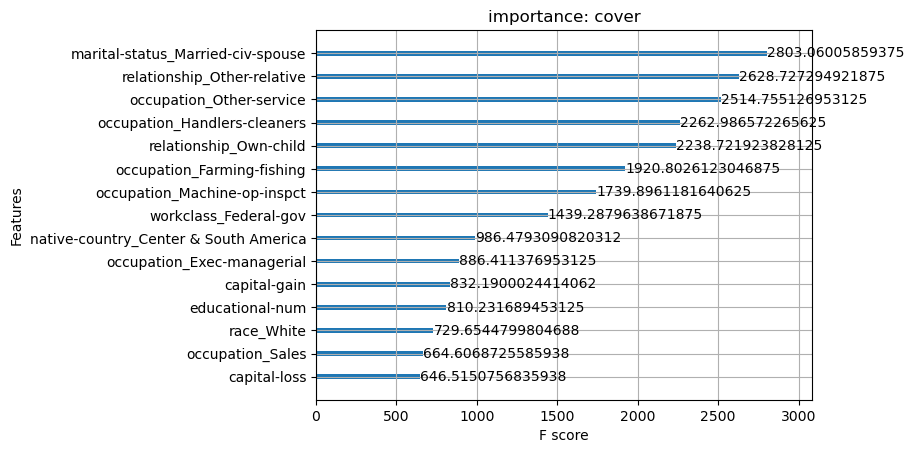

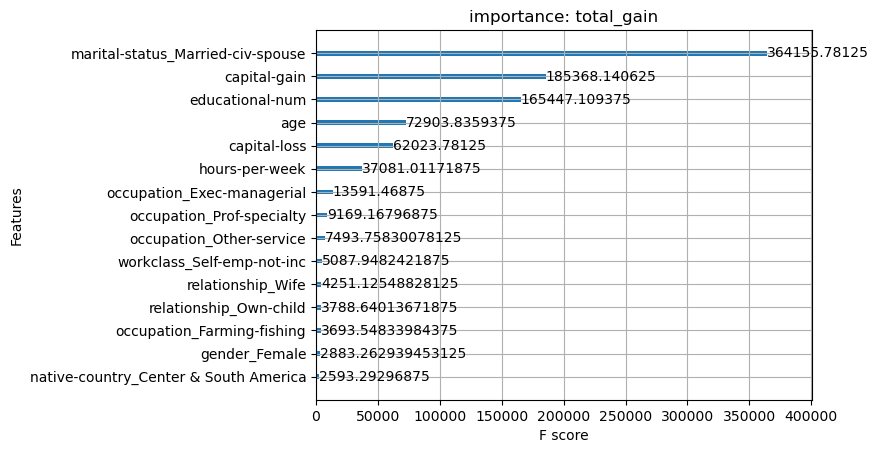

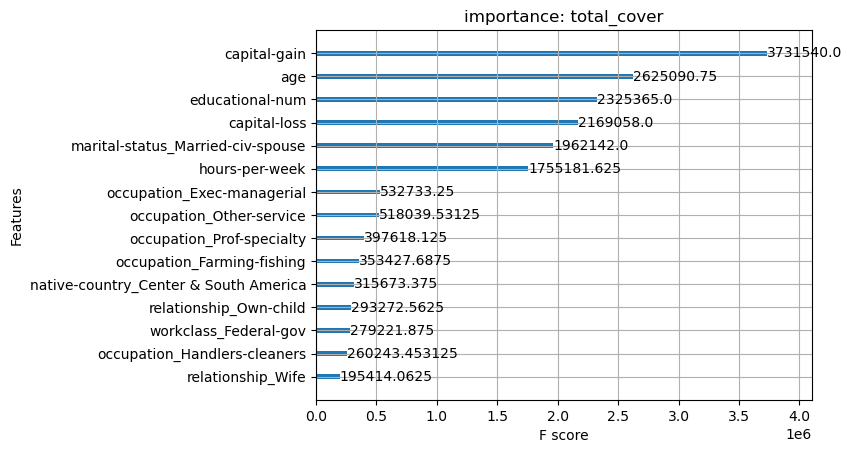

In [17]:
types= ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for f in types:
    xgb.plot_importance(xgb2 ,max_num_features=15, importance_type=f, title='importance: '+f);

XGBoost contient sa propre fonction xgb.cv() qui permet d'utiliser la validation croisée pour l'évaluation d'un modèle, sans avoir besoin de passer par un package externe.

Elle s'utilise de la même manière que train(), avec des arguments supplémentaires comme nfold pour choisir le nombre d'échantillons pour la validation croisée, et retourne un tableau des scores d'entraînement et de test pour chaque itération.

In [18]:
# Resultat cross validation à 3 échantillons
bst_cv = xgb.cv(params=params,
                dtrain=train,
                num_boost_round=100,
                nfold=3,
                early_stopping_rounds=60)

# Affichage
bst_cv


,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.687252,0.000030,0.687299,0.000018
1,0.681474,0.000058,0.681560,0.000042
2,0.675810,0.000086,0.675939,0.000059
3,0.670257,0.000115,0.670419,0.000081
4,0.664800,0.000133,0.664996,0.000086
...,...,...,...,...
95,0.407822,0.000839,0.410945,0.000400
96,0.406446,0.000844,0.409595,0.000394
97,0.405064,0.000838,0.408239,0.000395
98,0.403713,0.000850,0.406925,0.000395


In [20]:
# Stockage des proba de xgb2 sur test
preds = xgb2.predict(test)

# Création série
xgbpreds = pd.Series(np.where(preds > 0.5, 1, 0))

# Affichage matrice confusion
pd.crosstab(xgbpreds, pd.Series(y_test))


col_0,0,1
row_0,,
0,6326,763
1,358,1345


Il est possible obtenir l'erreur de prédiction du modèle sur un échantillon directement depuis une DMatrix, grâce à la méthode eval().

In [21]:
xgb2.eval(valid)


'[0]\teval-logloss:0.27994763732076589'

In [ ]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.1f}%".format(accuracy*100))

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm